In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
import tensorflow as tf
import keras
from keras import layers
import sys; sys.path.append('../')
from src.dataloader import spiral
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
regions = [
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,1,0,1],
    [1,0,0,0],
    [1,1,0,0]
]
xy = [
    (1,1),
    (1,2),
    (2,1),
    (0,-1),
    (-1,-1),
    (-0.5,1),
    (-1,0.5)
]

In [4]:
encoded = np.unique(np.asarray(regions)[:,:2], axis=0, return_inverse=True)[1]
clf1 = KNeighborsClassifier(n_neighbors=1)
clf1 = clf1.fit(xy, encoded)

encoded = np.unique(np.asarray(regions), axis=0, return_inverse=True)[1]
clf2 = KNeighborsClassifier(n_neighbors=1)
clf2 = clf2.fit(xy, encoded)

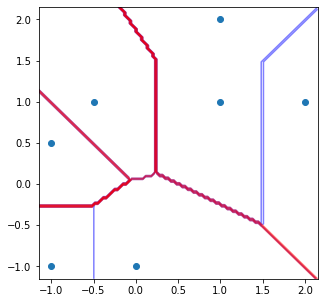

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
X, Y = list(zip(*xy))
ax.scatter(X, Y)

# plot the decision function
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

for clf, c in zip([clf2, clf1], ['blue', 'red']):
    # plot linear region boundaries
    Z = clf.predict(XY).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors=c, alpha=0.5)#, linestyles=['-'])

plt.show()

## Softmax network regions

In [2]:
from src.pipelines import EmbedCalibrate

In [7]:
n_samples = 2000
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.1)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

batch_size=100

# Initialize network for contrastive loss
network = keras.Sequential()
network.add(keras.layers.InputLayer((2,)))#, batch_size=batch_size))
network.add(layers.Dense(10, bias_initializer="glorot_uniform", activation='relu'))
network.add(layers.Dense(10, bias_initializer="glorot_uniform", activation='relu'))
network.add(layers.Dense(2, bias_initializer="glorot_uniform", activation='softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": 'acc',
}

fit_kwargs = {
    "epochs": 100,
    "batch_size": batch_size,
    "verbose": True
}

clf = EmbedCalibrate(network, softmax_kwargs, fit_kwargs)
clf = clf.fit(X, y)

Epoch 1/100
20/20 [==============================] - 0s 642us/step - loss: 0.6865 - acc: 0.5519
Epoch 2/100
20/20 [==============================] - 0s 677us/step - loss: 0.4831 - acc: 0.8750
Epoch 3/100
20/20 [==============================] - 0s 898us/step - loss: 0.2961 - acc: 0.8649
Epoch 4/100
20/20 [==============================] - 0s 788us/step - loss: 0.2750 - acc: 0.8711
Epoch 5/100
20/20 [==============================] - 0s 717us/step - loss: 0.2496 - acc: 0.8847
Epoch 6/100
20/20 [==============================] - 0s 672us/step - loss: 0.2534 - acc: 0.8839
Epoch 7/100
20/20 [==============================] - 0s 874us/step - loss: 0.2546 - acc: 0.8828
Epoch 8/100
20/20 [==============================] - 0s 966us/step - loss: 0.2576 - acc: 0.8780
Epoch 9/100
20/20 [==============================] - 0s 732us/step - loss: 0.2579 - acc: 0.8780
Epoch 10/100
20/20 [==============================] - 0s 653us/step - loss: 0.2451 - acc: 0.8832
Epoch 11/100
20/20 [===================

20/20 [==============================] - 0s 755us/step - loss: 0.0074 - acc: 0.9981
Epoch 86/100
20/20 [==============================] - 0s 733us/step - loss: 0.0091 - acc: 0.9963
Epoch 87/100
20/20 [==============================] - 0s 707us/step - loss: 0.0082 - acc: 0.9988
Epoch 88/100
20/20 [==============================] - 0s 660us/step - loss: 0.0081 - acc: 0.9972
Epoch 89/100
20/20 [==============================] - 0s 678us/step - loss: 0.0131 - acc: 0.9938
Epoch 90/100
20/20 [==============================] - 0s 644us/step - loss: 0.0045 - acc: 0.9997
Epoch 91/100
20/20 [==============================] - 0s 644us/step - loss: 0.0062 - acc: 0.9984
Epoch 92/100
20/20 [==============================] - 0s 636us/step - loss: 0.0064 - acc: 0.9972
Epoch 93/100
20/20 [==============================] - 0s 588us/step - loss: 0.0061 - acc: 0.9985
Epoch 94/100
20/20 [==============================] - 0s 578us/step - loss: 0.0079 - acc: 0.9964
Epoch 95/100
20/20 [=======================

In [87]:
def polytope_membership(network, X):
    width = len(network.layers)
    polytope_memberships = []
    last_activations = X
    
    for layer_id in range(width):
        weights, bias = network.layers[layer_id].get_weights()
        preactivation = np.matmul(last_activations, weights) + bias
        if layer_id == width - 1:
            binary_preactivation = (preactivation > 0.5).astype('int')
        else:
            binary_preactivation = (preactivation > 0).astype('int')
        polytope_memberships.append(binary_preactivation)
        last_activations = preactivation * binary_preactivation
#     polytope_memberships = np.tensordot(
#         np.concatenate(polytope_memberships, axis = 1),
#         2 ** np.arange(0, np.shape(np.concatenate(polytope_memberships, axis = 1))[1]),
#         axes = 1)

    return polytope_memberships

def polytope_activations(model, x):
    activations = []
    for layer in model.layers:
        x = layer(x)
        if hasattr(layer, 'activation'):
            if layer.activation == tf.keras.activations.relu:
                act = (x.numpy() > 0).astype(int)
            elif layer.activation == tf.keras.activations.softmax:
                act = (x.numpy() > 0.5).astype(int)
            activations.append(act)

    return activations

def plot_decision_boundaries(clf, X, y, layer_indices=None, n_activations=None, xlim=None, ylim=None, n_pts=100):
    if hasattr(clf, 'network_'):
        model = clf.network_
    else:
        model = clf
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], n_pts)
    yy = np.linspace(ylim[0], ylim[1], n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    # activations = polytope_membership(model, XY)
    activations = polytope_activations(model, XY)
    colors = ['red', 'blue', 'black']
    if layer_indices is None:
        acts = np.hstack(activations)
        Z = np.unique(acts, axis=0, return_inverse=True)[1].reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=colors[0], alpha=0.5)
    else:
        for c, i in zip(colors, layer_indices):
            acts = activations[i]
            Z = np.unique(acts, axis=0, return_inverse=True)[1].reshape(XX.shape)
            plt.contour(XX, YY, Z, colors=c, alpha=0.5)

    probs = clf.predict_proba(XY)
    
    z_plot = probs.max(1)
    z_plot = z_plot.reshape(XX.shape)
    
    vmax = 100
    vmin = 50
    plt.contourf(XX, YY, z_plot, alpha=0.2)#, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])

    plt.show()

Softmax boundary (black) is linear in each polytope defined by the boundaries from layer 1 (red) and layer 2 (blue)!

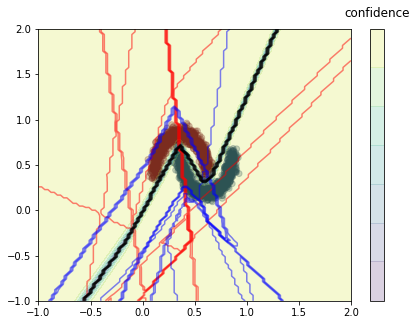

In [91]:
plot_decision_boundaries(clf, X, y, layer_indices = [0, 1, 2], ylim=[-1, 2], xlim=[-1, 2])